## Classification of one breed

This notebook is used to classify one breed of mice. The breed is c57bl6 and contains 12 mice. 3 of them will be used as validation set and the 9 others as training set. Only the third day of the experiment will be used.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import sys
sys.path.append('../Library')

import breedManip as breedManip
import dataProcessing as dataProcessing
import breeds as breeds
import splitData as splitData

import importlib
importlib.reload(splitData)

2023-07-04 18:51:20.316437: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 18:51:20.402938: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 18:51:21.760506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


<module 'splitData' from '/mnt/remote/workspaces/magali.egger/TBproject/Travail_Bachelor/ClassificationSimple/../Library/splitData.py'>

#### Preparation of the train and test set

In [2]:
with open('/home/magali.egger/workspace/TBproject/Travail_Bachelor/Data/df_simplify_day3.pkl', 'rb') as f:
    df = pickle.load(f)
df['breed'] = df['mouse'].apply(lambda x:breedManip.getBreedOfMouse(x))

In [3]:
df.head()

,Unnamed: 0,rawState,state,EEGv,EMGv,epoch,day,spectral_flatness,spectral_centroid,spectral_entropy,...,EMGv_max100,EEGv_log,EMGv_log,bias,EEGv^2,EEGv^3,EMGv^2,EMGv^3,mouse,breed
42018,43200,w,w,2.561793e-09,2.476193e-10,43200,2,0.156645,15.654199,-6.416485,...,6.798730e-10,-19.782559,-22.119129,1,6.562781e-18,1.681248e-26,6.131530e-20,1.518285e-29,09003,bxd_090
42019,43201,w,w,2.890715e-09,1.768662e-10,43201,2,0.146992,15.432471,-5.647920,...,6.798730e-10,-19.661762,-22.455627,1,8.356233e-18,2.415549e-26,3.128167e-20,5.532671e-30,09003,bxd_090
42020,43202,w,w,2.657057e-09,1.719997e-10,43202,2,0.096660,11.455600,-5.618493,...,6.798730e-10,-19.746047,-22.483528,1,7.059955e-18,1.875871e-26,2.958391e-20,5.088426e-30,09003,bxd_090
42021,43203,w,w,3.102465e-09,1.463278e-10,43203,2,0.085641,10.517584,-5.388146,...,6.798730e-10,-19.591069,-22.645172,1,9.625289e-18,2.986212e-26,2.141181e-20,3.133143e-30,09003,bxd_090
42022,43204,w,w,3.150835e-09,1.709445e-10,43204,2,0.098589,10.449326,-5.478330,...,6.798730e-10,-19.575598,-22.489682,1,9.927761e-18,3.128074e-26,2.922202e-20,4.995344e-30,09003,bxd_090


In [4]:
df = df[df['breed'] == 'c57bl6']

In [5]:
def split(df, seed):
    # take 3 random mice for test and the rest for train
    mice = df['mouse'].unique()
    np.random.seed(seed)
    np.random.shuffle(mice)
    mice_test = mice[:3]
    mice_train = mice[3:]
    df_train = df[df['mouse'].isin(mice_train)]
    df_test = df[df['mouse'].isin(mice_test)]
    return (df_train, df_test)

In [6]:
df_train, df_test = split(df, 42)

In [7]:
print(df_train['mouse'].unique())
print(df_test['mouse'].unique())

['BL611' 'BL6V2' 'BL606' 'BL601' 'BL6V1' 'BL610' 'BL609' 'BL614' 'BL612']
['BL6V3' 'BL616' 'BL602']


In [17]:
df_train = df_train.drop(columns=['mouse'])
df_test = df_test.drop(columns=['mouse'])

df_train = df_train.drop(columns=['breed'])
df_test = df_test.drop(columns=['breed'])

In [18]:
x_train, x_test, y_train, y_test, le = splitData.encode_scale_data(df_train, df_test, 13, cat_matrix=True)

#### Training of the model

In [19]:
rfc = RandomForestClassifier(random_state=13, class_weight="balanced", n_jobs=-1)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

[[19244   144   329]
 [  192  2309   140]
 [  654   124 35417]]
              precision    recall  f1-score   support

           n       0.96      0.98      0.97     19717
           r       0.90      0.87      0.89      2641
           w       0.99      0.98      0.98     36195

    accuracy                           0.97     58553
   macro avg       0.95      0.94      0.94     58553
weighted avg       0.97      0.97      0.97     58553



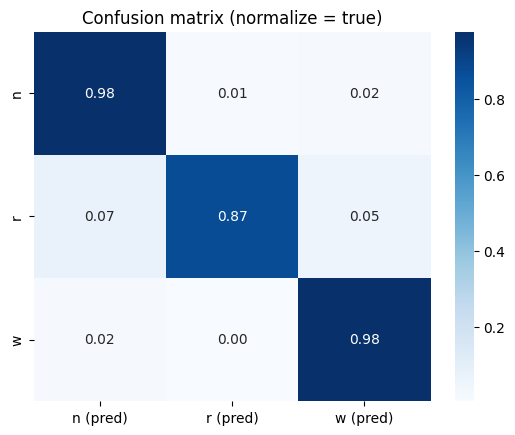

In [20]:
pred = np.argmax(y_pred, axis=1)
test = np.argmax(y_test, axis=1)

# plot the confusion matrix between predictions of the model and real values

cm = np.array(confusion_matrix(test, pred))
print(cm)

cm = np.array(confusion_matrix(test, pred, normalize='true')) # normalize = 'true' or 'pred'
confusion = pd.DataFrame(cm, index=le.classes_, columns=le.classes_ + ' (pred)')

print(classification_report(test, pred, target_names=le.classes_, zero_division=0))

sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()